<a href="https://colab.research.google.com/github/pietrocima/POSTag/blob/main/BILSTM_POSTagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Introduction

For our project we built an NLP system for Part-of-Speech tagging based on Bidirectional LSTM using the Pytorch library and datasets.

The Part-of-Speech tagging task can be describe as: *given a sequence of words **w**, find the most probable part-of-speech tags sequence **t** associated to the input sequence*. Each token in the input sequence must be paired with a specific tag, and these tags aim at dividing the words in different lexical categories based on the syntactic role in the sentence, i.e. words that play similar role in the syntactic structure of the sentence should be labeld with the same tag.

The complexity of the task lays in the fact that a high number of words, if taken independently, have many possible tags that can be correctly associated with them, and in order to find the correct tag of the word used in a given sentence, we must consider the context in which the word is used. This means that, in general, the POS tagging task is not just a classification task performed word by word, but consists of a structure prediction problem that can be solved with high accuracy only by working on the whole sentence.

Below, an example of such task with data taken directly from the datasets we use for the models.

In [ ]:
print("Sequence of words:")
print(['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.'], '\n')
print("Sequence of corresponding PoS tags:")
print(['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'])

Sequence of words:
['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.'] 

Sequence of corresponding PoS tags:
['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']




### Methods
The methodology we adopt cosnsist of: downloading the data and converting it to the correct input format, apply preprocessing when necessary. Then it proceeds with the instantiation two types of model: the BiLSTM and a baseline of floor performance using a "naive" model. The BiLSTM different architectures will span a grid of different parameters (embedding used, minimum frequency, layers and others) and the performance of these variations will be compared to each other and to the baseline over different datasets.

Our implementation was inspired by the  Pytorch BiLSTM for PoS tagging proposed by Ben Trevett on [github](https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb). We used the same dataset, same process of preparation of data, model setup, training and testing function. On top of that implementation, we added the dataset CoNLL-2000, the numsearch preprocessing, the conversion of datasets into raw tokens/tags lists; we also created the baseline from scratch, tested and evaluated it, then took the BiLSTM implementation and tried varying its parameters and architecture along with different types of embeddings, training and evaluating the performance across possible combinations of them to choose the best one. At the end of the notebook, we reported and compared the performance of the best-performing architecture, of two variations, and of the baseline, in order to observe and investigate causes and consequences of their behaviours.

It should be mentioned that we encountered a technical issue with the CoNLL-2000 dataset in the days before the delivery of the project. The external server of reference for the actual datasets in the official website (http://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz) stopped responding, making the notebook unable to retrieve the data with Pytorch. We tried to contact the administrator, who told us that fixing the technical issues would take some time. Therefore, we implemented the code in a way that in case the server will be fixed, the execution will include also that one corpus. But being unable to discuss the results at the current time, we had no choice other than leaving it out from the analysis.

The notebook was developed using colab, due to availability of better hardware for training the models and features for colaborative coding, but was tested also on Jupyter before delivery

# 2 - Data acquisition and initialization

The first step will be downloading *torchtext* package in a version that contains the datasets and functions used, then we import the necessary packages and functions. We then set the random seeds for reasons of reproducibility of the experiment.

In [ ]:
pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 14.2 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy import data
from torchtext.legacy import datasets

import numpy as np

# sklearn version 1.0 or higher are required to print the confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

import time
import random
import re
from tqdm import tqdm
from matplotlib import pyplot as plt
from math import floor, ceil

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset
The datasets used to evaluate our system was
[UD - Universal Dependencies](https://universaldependencies.org/): 16622 sentence, 254850 tokens, tagset of 18 tags;

For each dataset we use the extraction method described in the *torchtext.datasets* documentation, which automatically splits the dataset in training, validation and test subsets, then print their size in terms of sentence examples, and an actual example of them to visualize how the data is structured.
Then, we define some functions and variables that will be useful later, and use them to get some more informative content.
Having the data splits ready, we proceed in bulding the **vocabulary** taking advantage of the build_vocab method of the *torchtext.data.Field* class to build a *torchtext.vocab* object. Here we can set two experiment variables: the **minimum frequency** and the **embeddings**. The type of embedding is chosen from the set of predefined aliases in the class [*torchtext.vocab.vectors*](https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html#FastText) and loaded to be used later as initialization in the embedding layer of the BiLSTM.
At the end we define the batches for the system's training and send them to the device.



### CoNLL Dataset - CN tags

In [ ]:
try:
    TEXT1 = data.Field(lower = True)
    CN_TAGS = data.Field(unk_token = None)  # tell the field not to create an "unknown" tag, which would be added by default

    # Retrieve the Dataset and splits it into train, validation and test data
    fields1 = (("text", TEXT1), ("cntags", CN_TAGS), (None, None))
    train_data1, valid_data1, test_data1 = datasets.CoNLL2000Chunking.splits(fields1)

    # Print some information regarding the dataset
    print(f"Number of training examples: {len(train_data1)}")
    print(f"Number of validation examples: {len(valid_data1)}")
    print(f"Number of testing examples: {len(test_data1)}")
    print(f"Number of total examples sentences: {len(train_data1)+len(valid_data1)+len(test_data1)}")

    print("Example of training data instance: ")
    print(vars(train_data1.examples[0])['text'])
    print(vars(train_data1.examples[0])['cntags'])
except:
    print("\nThe CoNLL Dataset is not available")
    TEXT1 = None

downloading train.txt.gz

The CoNLL Dataset is not available


### UD Dataset -  UD tags

In [ ]:
TEXT2 = data.Field(lower = True)
UD_TAGS = data.Field(unk_token = None)  # tell the field not to create an "unknown" tag, which would be added by default

# Retrieve the Dataset and splits it into train, validation and test data
fields2 = (("text", TEXT2), ("udtags", UD_TAGS), (None, None))
train_data2, valid_data2, test_data2 = datasets.UDPOS.splits(fields2)

# Print some information regarding the dataset
print(f"Number of training examples: {len(train_data2)}")
print(f"Number of validation examples: {len(valid_data2)}")
print(f"Number of testing examples: {len(test_data2)}")
print(f"Number of total examples sentences: {len(train_data2)+len(valid_data2)+len(test_data2)}")

print("Example of training data instance: ")
print(vars(train_data2.examples[0])['text'])
print(vars(train_data2.examples[0])['udtags'])

downloading en-ud-v2.zip


en-ud-v2.zip: 100%|██████████| 688k/688k [00:00<00:00, 1.65MB/s]


extracting
Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077
Number of total examples sentences: 16622
Example of training data instance: 
['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']
['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


### UD Dataset - PTB tags

In [ ]:
TEXT3 = data.Field(lower = True)
PTB_TAGS = data.Field(unk_token = None)   # tell the field not to create an "unknown" tag, which would be added by default

# Retrieve the Dataset and splits it into train, validation and test data
fields3 = (("text", TEXT3), (None, None), ("ptbtags", PTB_TAGS))
train_data3, valid_data3, test_data3 = datasets.UDPOS.splits(fields3)

# Print some information regarding the dataset
print(f"Number of training examples: {len(train_data3)}")
print(f"Number of validation examples: {len(valid_data3)}")
print(f"Number of testing examples: {len(test_data3)}")
print(f"Number of total examples sentences: {len(train_data3)+len(valid_data3)+len(test_data3)}")

print("Example of training data instance: ")
print(vars(train_data3.examples[0])['text'])
print(vars(train_data3.examples[0])['ptbtags'])

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077
Number of total examples sentences: 16622
Example of training data instance: 
['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']
['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']


## Preprocessing the dataset: numsearch

Observing the original datasets and the vocabulary that we build later, we notice that tokens representing numbers are often considered unique words, despite having the same conceptual meaning of quantification. This can affect the performance of the models, because several numerical tokens (e.g dates, large numbers, numbers with fractional parts) will appear only once in the corpus, and therefore marked as infrequent type, like many others, resulting in a considerable probability of being misclassified. We try to add the human ability to generalize numeric text by submitting each token in the text to a regular expression that accepts numeric text of different structure. If the token is accepted, we substitute it in the text with the placeholder *'00000'*.

This operations realizes a new version of each dataset, which we define below.

In [ ]:
def numsearch(data_splits, numtoken, tagstype):
  """
  Function to scan the text and replace all generic number tokens that are accepted by the regex with numtoken
  """

  to_be_printed = {}
  for seq in data_splits:
      for example in seq.examples:
          current_sentence = vars(example)['text']
          curr_tags = vars(example)[tagstype]
          for i in range(len(current_sentence)):

              #Submit text to the regex search

              if re.search("^[0-9]+[,.:/]*[0-9]*[,.:/]*[0-9]*$", current_sentence[i]):
                  if (random.randint(0, 150) == 0):

                      #If accepted, substitute with placeholder

                      to_be_printed[current_sentence[i]] = curr_tags[i]

                  current_sentence[i] = numtoken

  print(to_be_printed)

In [ ]:
# definition of the placeholder
new_num_token = "00000"

### CoNLL Dataset with modified "number" tokens - CN tags

In [ ]:
# if the first dataset was loaded correctly
if TEXT1 is not None:
  TEXT1_num = data.Field(lower = True)
  CN_TAGS_num = data.Field(unk_token = None)   # tell the field not to create an "unknown" tag, which would be added by default

  # Retrieve the Dataset and splits it into train, validation and test data
  fields1_num = (("text", TEXT1_num), ("cntags", CN_TAGS_num), (None, None))
  train_data1_num, valid_data1_num, test_data1_num = datasets.CoNLL2000Chunking.splits(fields1_num)

  print("Some examples of numbers that will get replaced, and their current tag:")

  numsearch([train_data1_num, valid_data1_num, test_data1_num], new_num_token, 'cntags')

### UD Dataset with modified "number" tokens - UD tags

In [ ]:
TEXT2_num = data.Field(lower = True)
UD_TAGS_num = data.Field(unk_token = None)   # tell the field not to create an "unknown" tag, which would be added by default

# Retrieve the Dataset and splits it into train, validation and test data
fields2_num = (("text", TEXT2_num), ("udtags", UD_TAGS_num), (None, None), )
train_data2_num, valid_data2_num, test_data2_num = datasets.UDPOS.splits(fields2_num)

print("Some examples of numbers that will get replaced, and their current tag:")

numsearch([train_data2_num, valid_data2_num, test_data2_num], new_num_token, 'udtags')

Some examples of numbers that will get replaced, and their current tag:
{'42': 'NUM', '2': 'NUM', '65': 'NUM', '7': 'X', '01/11/2001': 'NUM', '10:51': 'NUM', '5': 'NUM', '2006': 'NUM', '1,700': 'NUM', '22': 'NUM', '3': 'NUM', '100,000': 'NUM', '1': 'NUM', '40': 'NUM', '713.864.4149': 'NUM', '13': 'NUM', '2009': 'NUM', '3,500,000': 'NUM', '22,750,000': 'NUM', '713': 'NUM'}


### UD Dataset with modified "number" tokens - PTB tags

In [ ]:
TEXT3_num = data.Field(lower = True)
PTB_TAGS_num = data.Field(unk_token = None)   # tell the field not to create an "unknown" tag, which would be added by default

# Retrieve the Dataset and splits it into train, validation and test data
fields3_num = (("text", TEXT3_num), (None, None), ("ptbtags", PTB_TAGS_num))
train_data3_num, valid_data3_num, test_data3_num = datasets.UDPOS.splits(fields3_num)

print("Some examples of numbers that will get replaced, and their current tag:")

numsearch([train_data3_num, valid_data3_num, test_data3_num], new_num_token, 'ptbtags')

Some examples of numbers that will get replaced, and their current tag:
{'7034': 'CD', '01/12/2001': 'CD', '08:22': 'CD', '1561': 'CD', '350,000': 'CD', '2005': 'CD', '100': 'CD', '5': 'CD', '16': 'CD', '12': 'CD', '2': 'CD', '13': 'CD', '3': 'CD', '7': 'CD'}


## Creation of vocabulary

In [ ]:
# Here we define lists of names or objects that are useful for testing the models on all the datasets by cycling over these lists

# if the first dataset was loaded correctly
if TEXT1 is not None:
    datasets_names = ["CoNLL-2000", "CoNLL-2000 with numsearch", "Universal Dependencies", "Universal Dependencies with numsearch", "Penn Treebanks", "Penn Treebanks with numsearch"]
    abbreviations = ['cntags', 'cntags', 'udtags', 'udtags', 'ptbtags', 'ptbtags']
    corpora = [[TEXT1, CN_TAGS],[TEXT1_num, CN_TAGS_num], [TEXT2, UD_TAGS], [TEXT2_num, UD_TAGS_num], [TEXT3, PTB_TAGS], [TEXT3_num, PTB_TAGS_num]]
    datas = [[train_data1, valid_data1, test_data1],[train_data1_num, valid_data1_num, test_data1_num],[train_data2, valid_data2, test_data2], [train_data2_num, valid_data2_num, test_data2_num], [train_data3, valid_data3, test_data3], [train_data3_num, valid_data3_num, test_data3_num]]

else:
    datasets_names = ["Universal Dependencies", "Universal Dependencies with numsearch", "Penn Treebanks", "Penn Treebanks with numsearch"]
    abbreviations = ['udtags', 'udtags', 'ptbtags', 'ptbtags']
    corpora = [[TEXT2, UD_TAGS], [TEXT2_num, UD_TAGS_num], [TEXT3, PTB_TAGS], [TEXT3_num, PTB_TAGS_num]]
    datas = [[train_data2, valid_data2, test_data2], [train_data2_num, valid_data2_num, test_data2_num], [train_data3, valid_data3, test_data3], [train_data3_num, valid_data3_num, test_data3_num]]

In [ ]:
def create_single_lists(input_data, tags_name):
    """
    Convert input data from a list of sentences to a single list of words and a single list of tags and save as object variables
    """
    input_text_single_list, input_tags_single_list = [], []

    #For every sentence in the input data, concatenate its tokens and tags to the list of words and list of tokens obtained so far

    for k in range(len(input_data.examples)):
        input_text_single_list.extend(vars(input_data.examples[k])['text'])
        input_tags_single_list.extend(vars(input_data.examples[k])[tags_name])
    return input_text_single_list, input_tags_single_list

In [ ]:
# Simple script to output number of tokens using the previous function
for i in range(len(datas)):
  allw = []
  for dataset in datas[i]:
    listw, listt = create_single_lists(dataset, abbreviations[i])
    allw.extend(listw)
  print(f'Total number of tokens in {datasets_names[i]} : {len(allw)}')

Total number of tokens in Universal Dependencies : 254850
Total number of tokens in Universal Dependencies with numsearch : 254850
Total number of tokens in Penn Treebanks : 254850
Total number of tokens in Penn Treebanks with numsearch : 254850


### Building the vocabs

In [ ]:
def vocab_build(train_data, min_freq, TEXT, TAGS):
    """
    Builds the vocabulary object for the field and data, marking as "unknown" the words with frequency < min_freq
    It also returns the index of the "pad" tag, which will be used later to avoid training the model on the padded part of the sentences
    """

    TEXT.build_vocab(train_data, min_freq = min_freq, vectors = "glove.840B.300d", unk_init = torch.Tensor.normal_)

    TAGS.build_vocab(train_data)

    TAG_PAD_IDX = TAGS.vocab.stoi[TAGS.pad_token]

    #print some information regarding the vocabulary
    print(f"Unique types in TEXT vocabulary: {len(TEXT.vocab)}")
    print(f"Unique tags in TAG vocabulary: {len(TAGS.vocab)}")

    print(TEXT.vocab.freqs.most_common(20))

    return TAG_PAD_IDX

In [ ]:
#Set  minimum frequency and initiate vocabulary building

MIN_FREQ = 2

if TEXT1 is not None:
    TAG_PAD_IDX1 = vocab_build(train_data1, MIN_FREQ, TEXT1, CN_TAGS)
    TAG_PAD_IDX1_num = vocab_build(train_data1_num, MIN_FREQ, TEXT1_num, CN_TAGS_num)

    TAG_PAD_IDX2 = vocab_build(train_data2, MIN_FREQ, TEXT2, UD_TAGS)
    TAG_PAD_IDX2_num = vocab_build(train_data2_num, MIN_FREQ, TEXT2_num, UD_TAGS_num)

    TAG_PAD_IDX3 = vocab_build(train_data3, MIN_FREQ, TEXT3, PTB_TAGS)
    TAG_PAD_IDX3_num = vocab_build(train_data3_num, MIN_FREQ, TEXT3_num, PTB_TAGS_num)

    tag_pads = [TAG_PAD_IDX1, TAG_PAD_IDX1_num, TAG_PAD_IDX2, TAG_PAD_IDX2_num, TAG_PAD_IDX3, TAG_PAD_IDX3_num]

else:
    TAG_PAD_IDX2 = vocab_build(train_data2, MIN_FREQ, TEXT2, UD_TAGS)
    TAG_PAD_IDX2_num = vocab_build(train_data2_num, MIN_FREQ, TEXT2_num, UD_TAGS_num)

    TAG_PAD_IDX3 = vocab_build(train_data3, MIN_FREQ, TEXT3, PTB_TAGS)
    TAG_PAD_IDX3_num = vocab_build(train_data3_num, MIN_FREQ, TEXT3_num, PTB_TAGS_num)

    tag_pads = [TAG_PAD_IDX2, TAG_PAD_IDX2_num, TAG_PAD_IDX3, TAG_PAD_IDX3_num]

.vector_cache/glove.840B.300d.zip: 2.18GB [06:53, 5.27MB/s]                            
100%|█████████▉| 2196016/2196017 [03:11<00:00, 11440.64it/s]


Unique types in TEXT vocabulary: 8866
Unique tags in TAG vocabulary: 18
[('the', 9076), ('.', 8640), (',', 7021), ('to', 5137), ('and', 5002), ('a', 3782), ('of', 3622), ('i', 3379), ('in', 3112), ('is', 2239), ('you', 2156), ('that', 2036), ('it', 1850), ('for', 1842), ('-', 1426), ('have', 1359), ('"', 1296), ('on', 1273), ('was', 1244), ('with', 1216)]
Unique types in TEXT vocabulary: 8580
Unique tags in TAG vocabulary: 18
[('the', 9076), ('.', 8640), (',', 7021), ('to', 5137), ('and', 5002), ('a', 3782), ('of', 3622), ('i', 3379), ('in', 3112), ('00000', 3043), ('is', 2239), ('you', 2156), ('that', 2036), ('it', 1850), ('for', 1842), ('-', 1426), ('have', 1359), ('"', 1296), ('on', 1273), ('was', 1244)]
Unique types in TEXT vocabulary: 8866
Unique tags in TAG vocabulary: 51
[('the', 9076), ('.', 8640), (',', 7021), ('to', 5137), ('and', 5002), ('a', 3782), ('of', 3622), ('i', 3379), ('in', 3112), ('is', 2239), ('you', 2156), ('that', 2036), ('it', 1850), ('for', 1842), ('-', 1426),

In [ ]:
BATCH_SIZE = 128

iter = []

# separates the data into batches of the desired size
for [train_data, valid_data, test_data] in datas:
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size = BATCH_SIZE,
        device = device)
    iter.append([train_iterator, valid_iterator, test_iterator])

# 3 - Baseline Model
This model is the implementation of the **Most Frequent Class Baseline** which we analyzed in class for the PoS tagging task: given a corpus of tokens and their associated PoS tags, it builds a dictionary in which each word in the vocabulary is associated to the tag it appears most frequently with in the corpus. Then we can apply the strategy from the literature for the evaluation of our system:

*Always compare a classifier against a baseline at
least as good as the most frequent class baseline (assigning each token to the class
it occurred in most often in the training set)*


We train one baseline for each dataset, where training consists just in building the aforementioned dictionary from the training and validation splits of the corpus converted by the *create_single_list* function.
Then we obtain the baseline precision by running the model on the converted test split, which will be useful for comparison with our system.

In [ ]:
class BaselineModel():
    """
    Baseline Model obtained by assigning at each word in the vocabulary the tag it is most frequently associated with
    """

    def __init__(self, train_data_l, fields, tags_name):
        self.train_data_l = train_data_l
        self.tags_name = tags_name
        self.TEXT_field = fields[0]
        self.TAGS_field = fields[1]
        self.model_core = {}
        self.train_text_single_list = []
        self.train_tags_single_list = []

    def training(self):

        temp_text, temp_tags = [], []
        for train_data in self.train_data_l:
          train_text_single_list, train_tags_single_list = create_single_lists(train_data, self.tags_name)
          temp_text.extend(train_text_single_list)
          temp_tags.extend(train_tags_single_list)

        self.train_text_single_list = temp_text
        self.train_tags_single_list = temp_tags


        word_ind = self.TEXT_field.vocab.stoi
        tags_ind = self.TAGS_field.vocab.stoi

        #Create table for Counts(tag,word), then argmax over columns to get most freq tag for word

        rf_tab = torch.zeros((len(self.TAGS_field.vocab.itos), len(self.TEXT_field.vocab.itos),)).to(device)

        # Iterate over all token in train_text_single_list

        for i in tqdm(range(len(self.train_text_single_list))):

            # increment the count of the tag associated to the token
            rf_tab[tags_ind[
                            self.train_tags_single_list[i]],
                   word_ind[
                            self.train_text_single_list[i]]] += 1

        rf_tab = torch.argmax(rf_tab, dim=0)

        # save the pair "word : most_frequent_tag" for every word in vocabulary (rf_tab columns)

        for k in range(len(rf_tab.tolist())):
            if (rf_tab[k] != 0):        # to avoid <pad> token
                self.model_core[self.TEXT_field.vocab.itos[k]] = self.TAGS_field.vocab.itos[rf_tab[k]]

        print("First 20 'type-tag' pairs in the Baseline model:")
        first_elems_of_model_core_dict = [key for key in list(self.model_core.keys())[0:20]]
        for k in first_elems_of_model_core_dict:
            print(str(k) +': ' + str(self.model_core[k]), end='  |  ')

    def inference(self, text):
        """
        handy method used to return the tags predicted by the baseline over an input text
        Note: text must be a list of words
        """
        return [self.model_core[token] for token in text]


## Training the Baseline

In [ ]:
# Instatiation of the baselines for the datasets

BL_models = []

for i in range(len(corpora)):

    [train, valid, test] = datas[i]

    print(f"Training Baseline Model on dataset {datasets_names[i]} \n")
    # For the baseline training we don't need a separate validation set, so we use it for training the model
    BL = BaselineModel([train, valid], corpora[i], abbreviations[i])
    BL.training()
    BL_models.append(BL)
    print('\n\n')

Training Baseline Model on dataset Universal Dependencies 



100%|██████████| 229753/229753 [00:03<00:00, 65623.54it/s]


First 20 'type-tag' pairs in the Baseline model:
<unk>: NOUN  |  the: DET  |  .: PUNCT  |  ,: PUNCT  |  to: PART  |  and: CCONJ  |  a: DET  |  of: ADP  |  i: PRON  |  in: ADP  |  is: AUX  |  you: PRON  |  that: SCONJ  |  it: PRON  |  for: ADP  |  -: PUNCT  |  have: VERB  |  ": PUNCT  |  on: ADP  |  was: AUX  |  


Training Baseline Model on dataset Universal Dependencies with numsearch 



100%|██████████| 229753/229753 [00:03<00:00, 65659.95it/s]


First 20 'type-tag' pairs in the Baseline model:
<unk>: NOUN  |  the: DET  |  .: PUNCT  |  ,: PUNCT  |  to: PART  |  and: CCONJ  |  a: DET  |  of: ADP  |  i: PRON  |  in: ADP  |  00000: NUM  |  is: AUX  |  you: PRON  |  that: SCONJ  |  it: PRON  |  for: ADP  |  -: PUNCT  |  have: VERB  |  ": PUNCT  |  on: ADP  |  


Training Baseline Model on dataset Penn Treebanks 



100%|██████████| 229753/229753 [00:03<00:00, 64696.70it/s]


First 20 'type-tag' pairs in the Baseline model:
<unk>: NNP  |  the: DT  |  .: .  |  ,: ,  |  to: TO  |  and: CC  |  a: DT  |  of: IN  |  i: PRP  |  in: IN  |  is: VBZ  |  you: PRP  |  that: IN  |  it: PRP  |  for: IN  |  -: HYPH  |  have: VBP  |  ": ``  |  on: IN  |  was: VBD  |  


Training Baseline Model on dataset Penn Treebanks with numsearch 



100%|██████████| 229753/229753 [00:03<00:00, 65729.66it/s]


First 20 'type-tag' pairs in the Baseline model:
<unk>: NNP  |  the: DT  |  .: .  |  ,: ,  |  to: TO  |  and: CC  |  a: DT  |  of: IN  |  i: PRP  |  in: IN  |  00000: CD  |  is: VBZ  |  you: PRP  |  that: IN  |  it: PRP  |  for: IN  |  -: HYPH  |  have: VBP  |  ": ``  |  on: IN  |  




## Evaluating the Baseline

In [ ]:
def evaluateBL(BL_model, test_data, tags_name):

    #Convert data

    test_data_single_list, test_tags_single_list = create_single_lists(test_data, tags_name)


    # Filtering the converted test list by substituting tokens that are unknow to the model with the <unk> placeholder
    # The tokens that are unknown to the model are the ones which are not present as key in the model_core dictionary,
    # so the ones which did not appear in the train data


    test_data_single_list_unk = []
    for token in test_data_single_list:
        if token in BL_model.model_core:
            test_data_single_list_unk.append(token)
        else:
            test_data_single_list_unk.append('<unk>')

    model_prediction = BL_model.inference(test_data_single_list_unk)

    #Accuracy is computed by counting the number of correct predictions (predicted == gold) and dividing it by the length of the input

    accuracy_count = [1 for predicted, gold in zip(model_prediction, test_tags_single_list) if predicted == gold]

    accuracy = len(accuracy_count)/len(test_tags_single_list)
    return accuracy

In [ ]:
BL_accuracies = []

for i in range(len(BL_models)):
    [train, valid, test] = datas[i]

    print(f"Evaluating Baseline Model on dataset {datasets_names[i]} \n")

    BL = BaselineModel(train, corpora[i], abbreviations[i])
    accuracy = evaluateBL(BL_models[i], test, abbreviations[i])

    print(f'Test Acc: {accuracy*100:.2f}% \n')

    BL_accuracies.append(accuracy)

print(f'Average Most Frequent Class Baseline test accuracy (over all datasets): {sum(BL_accuracies)/len(BL_accuracies)}')

Evaluating Baseline Model on dataset Universal Dependencies 

Test Acc: 84.58% 

Evaluating Baseline Model on dataset Universal Dependencies with numsearch 

Test Acc: 85.27% 

Evaluating Baseline Model on dataset Penn Treebanks 

Test Acc: 83.72% 

Evaluating Baseline Model on dataset Penn Treebanks with numsearch 

Test Acc: 84.40% 

Average Most Frequent Class Baseline test accuracy (over all datasets): 0.8449416264892218


# 4 - Bidirectional LSTM

Our system consists in a Bidirectional LSTM, which is widely used in the literature for the task we work on and in general for NLP tasks ([Peilu Wang, Yao Qian, Frank K. Soong, Lei He, Hai Zhao](https://arxiv.org/abs/1510.06168);  [Steinþór Steingrímsson, Örvar Kárason, Hrafn Loftsson](https://aclanthology.org/R19-1133.pdf)) thanks to its ability to consider unbounded context windows of the inputs.
Given that at time t, $x_t$ is the input word, $e(x_t)$ its embedding, $h_t$ the hidden state and $c_t$ the cell state, $y_t$ the predicted tag and $f$ a linear transformation, the BiLSTM consists in the implementation of the following functions.
<br>

 $$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$
$$h_t = [h^{\rightarrow}_t;h^{\leftarrow}_{t}]$$
 $$\hat{y}_t = f(h_t)$$

<br>

Our Pytorch implementation is structured in the following way:
1. **Embedding layer** - Input dimension: word vocabulary size, Output dimension: embedding size. Input token is represented as one-hot-vector with size of the word vocabulary, the output is the neural embedding of the said token;
2. **BiLSTM layer** - Input dimension: embedding size, Output dimension: hidden layer size. Output is obtained by passing input over a number *n_layers* of LSTMs, each one set to be bidirectional, so that outputs holds the backward and forward hidden states in the final layer. In this layer we can set the experiment variables **Number of layers**, **Dropout** and **Hidden layer dimension**;
3. **Linear layer** - Input dimension: hidden layer size, Output dimension: tagset size. Output is obtained simply passing the input over a fully-connected linear layer, then dropout is applied again to get the distribution of probability weights over the tagset;

After defining the implementation as a class, we declare the constants and instantiate one model for each dataset, as they will be trained separately on each of them. *embedding dim* has to be the same of the embedding chosen when building the vocabulary (e.g. Using *GloVe 840B 300d* requires to have embedding_dim=300).


In [ ]:
class BiLSTMPOSTagger(nn.Module):
    """
    BiLSTM class definition
    """

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout,
                 pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [sent len, batch size]
        embedded = self.dropout(self.embedding(text))

        #embedded = [sent len, batch size, emb dim]
        outputs, _ = self.lstm(embedded)

        #output = [sent len, batch size, hid dim * n directions]
        predictions = self.fc(self.dropout(outputs))

        #predictions = [sent len, batch size, output dim]

        return predictions

In [ ]:
#Declaration of the model's parameters and initialization of the model instances

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.125
pad_idxs = []
modelsBiLSTM = []

#Create one model for each corpus in corpora

for [TEXT,TAGS] in corpora:
    INPUT_DIM = len(TEXT.vocab)
    OUTPUT_DIM = len(TAGS.vocab)
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    model = BiLSTMPOSTagger(INPUT_DIM,
                            EMBEDDING_DIM,
                            HIDDEN_DIM,
                            OUTPUT_DIM,
                            N_LAYERS,
                            BIDIRECTIONAL,
                            DROPOUT,
                            PAD_IDX)
    pad_idxs.append(PAD_IDX)
    modelsBiLSTM.append(model)


In [ ]:
#Function that initializes randomly the model's weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)


#Function that prints the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training and evaluating the BiLSTM
For every corpus in the corpora, we initialize the model's weigths and load the previously loaded embeddings as weigths of the Embedding layer in the BiLSTM, initializing to zero-vectors the padding tokens embeddings. We define Adam as optimizer and Cross Entropy as loss, an "optimizer-loss" pair is saved for each model instance because they are initialized with data specific for the model.
We define the function *categorical_accuracy* to find the most probable label as argmax of the softmax, then compute the accuracy (also called precision) given a set of predicted labels and one of golden labels, by comparing the sets restricting to the labels belonging to tokens different than \<pad\>.

Then in the training procedure we iterate over several batches by zeroing the gradient, getting the prediciton from the sentences as string of labels, computing the loss and the accuracy and use them to make an optimizer step. Then report the mean accuracy over the batches. The procedure is ran using the training set to adjust the weights of the model and minimize the loss.

The evaluation sequence is defined similarly to the training one, but there is no weight update and it is performed on the test set (or on the validation set during the training).

Once defined the procedures, the actual training starts: in each of the 10 epochs the model is trained on the training data and evaluated on the validation data. If the validation loss of the current epoch is better than the previous lowest one we save the current model, so that the model saved at the end of the training will be the one that produced the best validation loss. After that, the model's prediction for the test set are obtained. The whole procedure is repeated for each corpus, obtaining four (or six, if CoNLL is available) different models.

In [ ]:
optimizers = []
criterions = []

for i in range(len(corpora)):
    model = modelsBiLSTM[i]
    TAG_PAD_IDX = tag_pads[i]
    PAD_IDX = pad_idxs[i]
    TEXT = corpora[i][0]

    #Initialize weights randomly

    model.apply(init_weights)
    print(f'The model {i} has {count_parameters(model):,} trainable parameters')

    #Initialize Embedding layer with pre-loaded embeddings

    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    #Optimizer and Loss

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


    model = model.to(device)
    criterion = criterion.to(device)

    optimizers.append(optimizer)
    criterions.append(criterion)

The model 0 has 5,388,778 trainable parameters
The model 1 has 5,302,978 trainable parameters
The model 2 has 5,405,707 trainable parameters
The model 3 has 5,319,907 trainable parameters


In [ ]:
#Function that takes label prediction and golden label and computes accuracy

def categorical_accuracy(model_predictions, gold_tags, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = model_predictions.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (gold_tags != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(gold_tags[non_pad_elements])
    return correct.sum() / gold_tags[non_pad_elements].shape[0], [max_preds[non_pad_elements].squeeze(1), gold_tags[non_pad_elements]]

In [ ]:
def train(model, iterator, optimizer, criterion, tag_pad_idx, i):
    """
    BiLSTM training function
    """

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        text = batch.text

        if TEXT1 is not None:
            if (i == 0 or i == 1): tags = batch.cntags
            elif (i == 2 or i == 3): tags = batch.udtags
            else: tags = batch.ptbtags

        else:
            if (i == 0 or i == 1): tags = batch.udtags
            else: tags = batch.ptbtags

        optimizer.zero_grad()

        #text = [sent len, batch size]

        predictions = model(text)

        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]

        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]

        loss = criterion(predictions, tags)

        acc, _ = categorical_accuracy(predictions, tags, tag_pad_idx)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, tag_pad_idx, i):
    """
    BiLSTM evaluation function
    """


    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    returnlabels = []

    with torch.no_grad():

        for batch in iterator:

            text = batch.text

            if TEXT1 is not None:
              if (i == 0 or i == 1): tags = batch.cntags
              elif (i == 2 or i == 3): tags = batch.udtags
              else: tags = batch.ptbtags

            else:
                if (i == 0 or i == 1): tags = batch.udtags
                else: tags = batch.ptbtags

            predictions = model(text)

            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            loss = criterion(predictions, tags)

            acc, labels = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            returnlabels.append(labels)


    return epoch_loss / len(iterator), epoch_acc / len(iterator), returnlabels

In [ ]:
def epoch_time(start_time, end_time):
    """
    Print how much time an epoch takes
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Actual training instance using training data
# Validation data is used to find the model which perform better on the validation and avoid eccessive overfitting

N_EPOCHS = 10

savemodel_names = []

# iterates over the various dataset
for i in range(len(corpora)):

    best_valid_loss = float('inf')
    model = modelsBiLSTM[i]
    [train_iterator, valid_iterator, test_iterator] = iter[i]
    TAG_PAD_IDX = tag_pads[i]
    print(f"Training BiLSTM on dataset {datasets_names[i]} \n")
    savemodel_names.append('bilstm' + abbreviations[i] + str(i) + '-model.pt')

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = train(model, train_iterator, optimizers[i], criterions[i], TAG_PAD_IDX, i)
        valid_loss, valid_acc, _ = evaluate(model, valid_iterator, criterions[i], TAG_PAD_IDX, i)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        #If current validation loss is lower than the better so far, substitute the model with the current

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), savemodel_names[i])
            print("Saved model as " + savemodel_names[i])

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print("\n\n")

Training BiLSTM on dataset Universal Dependencies 

Saved model as bilstmudtags0-model.pt
Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.781 | Train Acc: 75.82%
	 Val. Loss: 0.444 |  Val. Acc: 87.02%
Saved model as bilstmudtags0-model.pt
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.233 | Train Acc: 92.65%
	 Val. Loss: 0.377 |  Val. Acc: 88.72%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.167 | Train Acc: 94.65%
	 Val. Loss: 0.384 |  Val. Acc: 87.10%
Saved model as bilstmudtags0-model.pt
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.133 | Train Acc: 95.68%
	 Val. Loss: 0.353 |  Val. Acc: 88.76%
Saved model as bilstmudtags0-model.pt
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.107 | Train Acc: 96.47%
	 Val. Loss: 0.338 |  Val. Acc: 90.47%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.086 | Train Acc: 97.23%
	 Val. Loss: 0.350 |  Val. Acc: 90.42%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.068 | Train Acc: 97.80%
	 Val. Loss: 0.359 |  Val. Acc: 90.09%
Epoch: 08 | Epoch Time: 0m 5s
	Train Los

In [ ]:
#Evaluation of BiLSTM on test data

labels4datas = []

for i in range(len(corpora)):

    model = modelsBiLSTM[i]
    model.load_state_dict(torch.load(savemodel_names[i]))

    test_loss, test_acc, labels = evaluate(model, iter[i][2], criterions[i], tag_pads[i], i)

    print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

    labels4datas.append(labels)

Test Loss: 0.344 |  Test Acc: 89.78%
Test Loss: 0.329 |  Test Acc: 90.46%
Test Loss: 0.415 |  Test Acc: 88.84%
Test Loss: 0.417 |  Test Acc: 89.23%


# 5 - Testing the models without pretrained embeddings

As a further analysis step of our system, we wanted to investigate and measure the effectiveness of using structured embeddigs. We did this by training a second instance of the BiLSTM, avoiding the initialization with the pretrained embeddings. This sets the weights of the Embedding layer randomly, then we train the model (including the Embedding layer weights) on the same corpora to collect the performances and compare them with the model that uses the pretrained embeddings.

The cells below are identical to the cells used above to create, train and evaluate the models. The only difference can be found in the second cell, where we avoid copying the pretrained GLoVe embeddings into the weights of the Embedding layers.

In [ ]:
#Declaration of the model's parameters and initialization of the model instances

pad_idxs_no_emb = []
modelsBiLSTM_no_emb = []

#Create one model for each corpus in corpora

for [TEXT,TAGS] in corpora:
    INPUT_DIM = len(TEXT.vocab)
    OUTPUT_DIM = len(TAGS.vocab)
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    model = BiLSTMPOSTagger(INPUT_DIM,
                            EMBEDDING_DIM,
                            HIDDEN_DIM,
                            OUTPUT_DIM,
                            N_LAYERS,
                            BIDIRECTIONAL,
                            DROPOUT,
                            PAD_IDX)
    pad_idxs_no_emb.append(PAD_IDX)
    modelsBiLSTM_no_emb.append(model)


In [ ]:
optimizers_no_emb = []
criterions_no_emb = []

for i in range(len(corpora)):
    model = modelsBiLSTM_no_emb[i]
    TAG_PAD_IDX = tag_pads[i]
    PAD_IDX = pad_idxs_no_emb[i]
    TEXT = corpora[i][0]

    #Initialize weights randomly

    model.apply(init_weights)
    print(f'The model {i} has {count_parameters(model):,} trainable parameters')

    #### Only change with respect to the cells above
    #### The weight of the embedding layer are not initialized using the pretrained embedding

    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    #Optimizer and Loss

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


    model = model.to(device)
    criterion = criterion.to(device)

    optimizers_no_emb.append(optimizer)
    criterions_no_emb.append(criterion)

The model 0 has 5,388,778 trainable parameters
The model 1 has 5,302,978 trainable parameters
The model 2 has 5,405,707 trainable parameters
The model 3 has 5,319,907 trainable parameters


In [ ]:
# Actual training instance using training data
# Validation data is used to find the model which perform better on the validation and avoid eccessive overfitting by doing so

N_EPOCHS = 10

savemodel_names_no_emb = []

for i in range(len(corpora)):

    best_valid_loss = float('inf')
    model = modelsBiLSTM_no_emb[i]
    [train_iterator, valid_iterator, test_iterator] = iter[i]
    TAG_PAD_IDX = tag_pads[i]
    print(f"Training BiLSTM on dataset {datasets_names[i]} \n")
    savemodel_names_no_emb.append('bilstm' + abbreviations[i] + str(i) + '-model.pt')

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = train(model, train_iterator, optimizers_no_emb[i], criterions_no_emb[i], TAG_PAD_IDX, i)
        valid_loss, valid_acc, _ = evaluate(model, valid_iterator, criterions_no_emb[i], TAG_PAD_IDX, i)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        #If current validation loss is lower than the better so far, substitute the model with the current

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), savemodel_names_no_emb[i])
            print("Saved model as " + savemodel_names_no_emb[i])

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print("\n\n")



Training BiLSTM on dataset Universal Dependencies 

Saved model as bilstmudtags0-model.pt
Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.111 | Train Acc: 65.31%
	 Val. Loss: 0.585 |  Val. Acc: 84.01%
Saved model as bilstmudtags0-model.pt
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.268 | Train Acc: 91.68%
	 Val. Loss: 0.458 |  Val. Acc: 86.66%
Saved model as bilstmudtags0-model.pt
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.169 | Train Acc: 94.69%
	 Val. Loss: 0.413 |  Val. Acc: 89.06%
Saved model as bilstmudtags0-model.pt
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.128 | Train Acc: 95.89%
	 Val. Loss: 0.406 |  Val. Acc: 89.32%
Saved model as bilstmudtags0-model.pt
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.101 | Train Acc: 96.77%
	 Val. Loss: 0.405 |  Val. Acc: 89.31%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.077 | Train Acc: 97.55%
	 Val. Loss: 0.410 |  Val. Acc: 89.54%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.058 | Train Acc: 98.19%
	 Val. Loss: 0.413 |  Val. Acc: 89.54%
Ep

In [ ]:
#Evaluation of BiLSTM on training data

labels4datas_no_emb = []

for i in range(len(corpora)):

    model = modelsBiLSTM_no_emb[i]
    model.load_state_dict(torch.load(savemodel_names_no_emb[i]))

    test_loss, test_acc, labels = evaluate(model, iter[i][2], criterions_no_emb[i], tag_pads[i], i)

    print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

    labels4datas_no_emb.append(labels)

Test Loss: 0.420 |  Test Acc: 88.85%
Test Loss: 0.389 |  Test Acc: 88.43%
Test Loss: 0.542 |  Test Acc: 86.69%
Test Loss: 0.509 |  Test Acc: 87.84%


# 6 - System Analysis and Results Comparison
We evaluate our PoS tagging system and its variations by taking as reference metric the **accuracy** on the test set (percentage of test
set tags that match human gold labels) computed by the function *categorical_accuracy* to make comparisons across different variation and with the baseline.

1. #### Baseline - Most Frequent Class and Baseline_num
We report the accuracy of the baseline described in Section 3 (which has no uncertainty due to the deterministic approach it is based on) and also of its correspective trained and tested on the numsearch-preprocessed datasets.


2. #### BiLSTM1 - GloVe 840B 300d, 2 layers, 256 hidden states, 0.125 dropout
The second part of the system we evaluate is the BiLSTM whose architecture is described by the table below, where V is the size of the vocabulary and T the size of the tagset. The model's parameters have been set after evaluating several model with different combinations of parameters in a 4-dimensional grid. The hyperparameters of the model used in the final implementation are the ones which had the best performance on the validation set.

 The embeddings used are the GloVe 840B 300d, i.e. a set of embeddings for 840 billion words using 300 features each, obtained with the GloVe method. The other options we tried were Char N-gram 100d (100-dimensional N-grams), English fastText 300d (300-dimensional fastText for english) and Glove 6B 100d (embeddings for 6 billion words with dimension 100 using GloVe), but Glove 840B 300d turned out to have the best performances. It should be mentioned that numsearch preprocessing had almost no effect on the system when fastText was used. This could be explained considering the subword-based strategy used by such type of neural embedding, which is probably better at generalizing numerical tokens.
<br>

|| Input dim |Output dim | Dropout|
| ----- | ----- | ----- | ----- |
| Embedding | V | 300 | 0 |
| BiLSTM | 300 | 256 (x2) |0.125|
| Linear | 256 (x2) | T |0.125|

<br>

3. #### BiLSTM_num - BiLSTM with numsearch preprocessing
We evaluate the system variation where we use the architecture described at the previous point, on the datasets we preprocessed with the numsearch function. We expect to have a slightly higher accuracy due to the fact that the numerical tokens label prediction is facilitated.
<br>

4. #### BiLSTM_noemb - BiLSTM with random initialization
Another version of our system makes use of the previously introduced random weight initialization in the embedding layer instead of the pre-trained embeddings (Section 5). We expect this model to perform worse than the previous two due to the fact that the first layer does not inherit general contextual nor lexical semantic information before training, as it does in other cases.  
<br><br>





## Accuracy

The results of the accuracy for each model on each dataset are reported in the table below.
They confirm the hypotheses on their behaviour: BiLSTM_noemb has the worst accuracy across the variations, but it gets higher including the structured embeddings in BiLSTM1, then improves again with the numsearch preprocessing. Generally, performances were better for the UD tagset compared with the PTB tagset, due to its way lower cardinality.  Regardless, they all perform better than the baseline, which satisfies the condition in Section 3.


We can observe that the baseline model is the one that improves the most when we add the numsearch preprocessing. This is because numerical tokens that had frequency lower than MIN_FREQ were all converted to \<unk\>. In the end \<unk\> had a lot of possible tags and only the most frequent was actually assigned (which was in fact NOUN/NNP), causing misclassification of all the numerical tokens with low frequency (their number is around 600, comparing the vocabulary sizes before and after preprocessing). By using numsearch, we incorporate those tokens under a single token with high frequency and unambiguous tag that is easily predictable as NUM/CD by the baseline. This is also valid in a different and less strong way for the BiLSTM, as the \<unk\> token has an embedding obtained from totally different context that results in high uncertainty and a more flattened tag probabilities distribution.

<br>


|| Universal Dependencies | Penn Treebank | Average over corpora
| --- | --- | --- | --- |
| Baseline | 84.58% | 83.72% | 84.15%
| Baseline_num | 85.27% | 84.40%|  84.83%
|BiLSTM1| 89.64% ± 0.5%| 88.84% ± 0.5%| 89.24%
|BiLSTM_num| 90.33% ± 0.5%| 89.27% ± 0.5%| 89.80%
|BiLSTM_noemb| 87.12% ± 0.5%| 87.21% ± 0.5%| 87.17%

<br>

We set the minimum frequency at MIN_FREQ = 2 after evaluating also MIN_FREQ = 1 and MIN_FREQ = 3 as possible options and collecting the accuracy in a similar way, which is displayed underneath. We observed that among the discarded options, MIN_FREQ = 1 caused the baseline to have higher accuracy (due to having less \<unk\> words mapped all into the most frequent tag) and BiLSTM1 to have it lower (almost like the baseline) due to the higher number of words that occur rarely. On the other hand, MIN_FREQ = 3 caused the baseline to lose around 2% accuracy and BiLSTM1 to lose around 0.5% as well (with respect to the performance with MIN_FREQ = 2). This shows that BiLSTM models are able to counteract the high number of unknown tokens much better than the simple baseline model, thanks to the ability of the neural model to consider the context of the tokens while doing predictions.
<br>

|||||||||minimum frequency: 1| |minimum frequency: 3|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |

|  |  | UD |PTB | UD |PTB |
| --- | --- | --- | --- | --- | --- |
| Baseline | | 86.15% | 84.95% | 83.95% | 81.79%||||
| Baseline_num | | 86.76% | 85.56% | 84.67%|  82.52%||||
|BiLSTM1| | 86.88% ± 0.5% | 86.71% ± 0.5%| 89.38% ± 0.5%| 88.22% ± 0.5%||||
|BiLSTM_num| | 90.07% ± 0.5% | 86.89% ± 0.5%| 90.10% ± 0.5%| 88.72% ± 0.5%||||

## Confusion Matrix

At last, we generate the normalized Confusion Matrix of the Pos tags predictions of the system on both Universal Dependencies and Penn Treebank, non-preprocessed and preprocessed (hence, the predictions belong to BiLSTM1 and BiLSTM_num). The matrices are very informative (we printed the numerical values only for the UD ones for visualization reasons), they are both dominant along the main diagonal which is proof of a correct predictive behavior. The most relevant false predictions in the Universal Dependencies (e.g. counts not on the main diagonal) arise from misclassification of NOUN into PROPN and vice versa, neverthless it is not that high considering the complexive number of NOUN and PROPN correctly classified (nearly 10 times more). In the Penn Treebank dataset, the only non-negligible misclassification is relative to NNP as NN and vice versa, which is understandable from a linguistic point of view, and around 10% of the correct ones anyway.

We observe that adding the numsearch preprocessing moved a certain amount of predictions, for the relative numerical tag, into the main diagonal (38 in UD, 60 in PTB, i.e. 5-15% of the total) and out of the vertical and horizontal axes regardless, confirming the disambiguating effect of the technique.


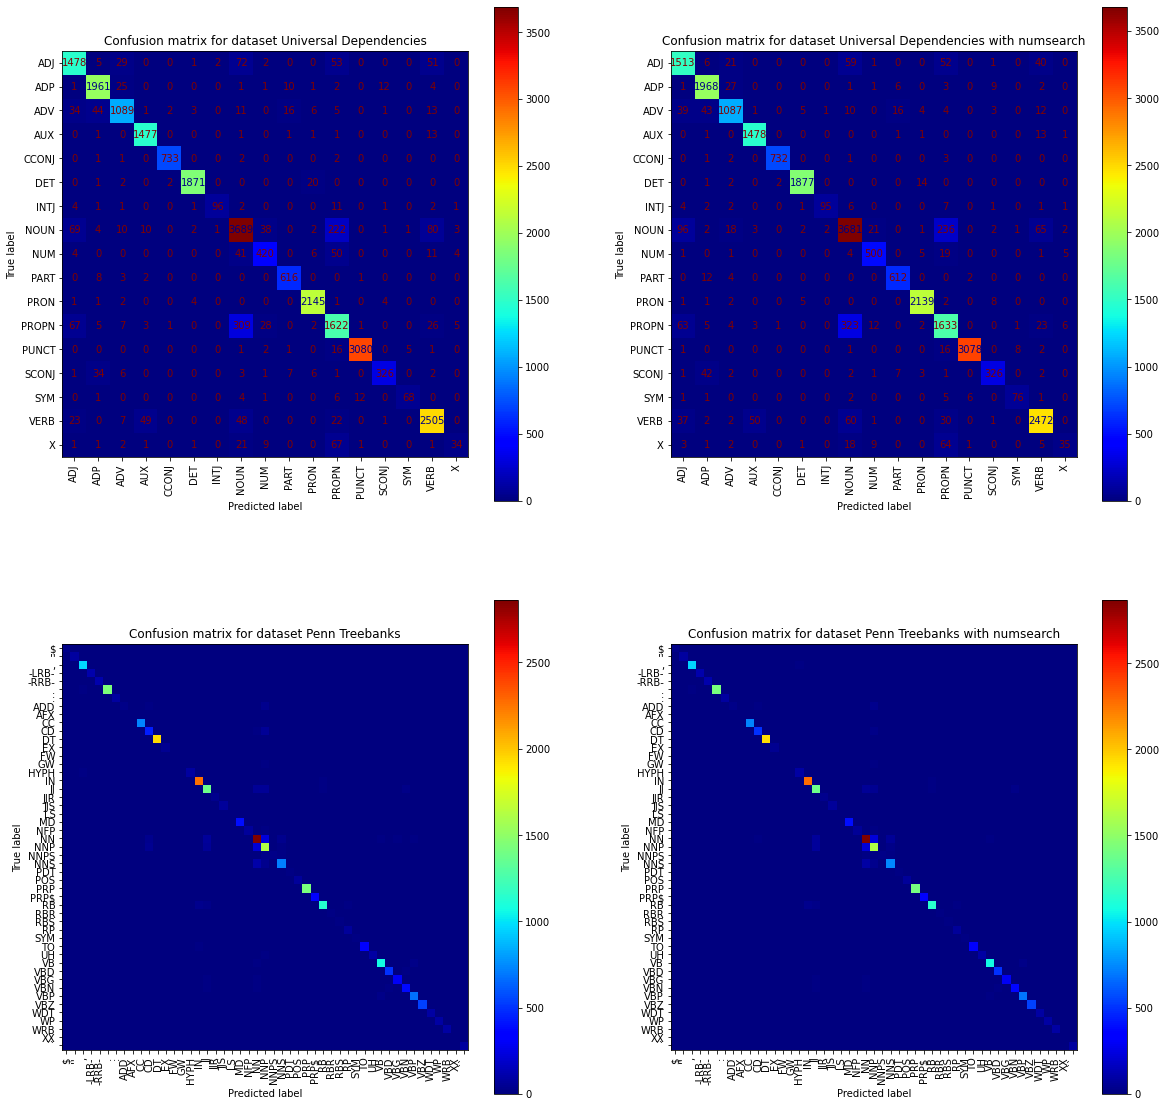

In [ ]:
fig, axes = plt.subplots(nrows=ceil(len(datasets_names)/2), ncols=2, figsize=(20, 20))

predicted_tags_vec = []

for i in range(len(datasets_names)):
  ax = axes[floor(i/2), i%2]
  ax.set_xlabel('$Predicted tags$')
  ax.set_ylabel('$True tags$')

  labels = labels4datas[i]

  predicted_labels_list = []
  true_labels_list = []

  for batch in labels:
      predicted_labels_list.extend(batch[0].squeeze(1).tolist())
      true_labels_list.extend(batch[1].squeeze(1).tolist())



  index_to_tag = corpora[i][1].vocab.itos

  predicted_tags = [index_to_tag[j] for j in predicted_labels_list]
  true_tags = [index_to_tag[j] for j in true_labels_list]
  predicted_tags_vec.append(predicted_tags)

  #Generate the confusion matrix

  disp = ConfusionMatrixDisplay.from_predictions(true_tags,
                                                 predicted_tags,
                                                 ax = ax,
                                                 xticks_rotation="vertical",
                                                 include_values = True if (datasets_names[i] == "Universal Dependencies" or
                                                                           datasets_names[i] == "Universal Dependencies with numsearch")
                                                                       else False,
                                                 cmap = 'jet'
                                                 )

  ax.set_title(f"Confusion matrix for dataset {datasets_names[i]}")



plt.show()

# 7 - Conclusion

Given the results obtained from the previous section, we have been able to analyse interesting properties of the corpora and of the models. We showed an easily implementable baseline, its properties and performance, then we did the same for a Neural PoS tagger which is the foundation of many state-of-the-art models. We worked on their features to model their behavior and target possible strenghts and weaknesses, and added a preprocessing step for disambiguating predictions by including the human ability to generalize numerical words, and showed its influence on the models. On the top of this, we found that the system we implemented showed fairly good performances and properties in the part-of-speech tagging task on different corpora, and can be easily expanded to reach further improvements.